## The problem
Predicting the value of a house from set of parameters - univariate multiple regression problem. 

Classifying if the house is worth above or below 1,000,000 USD - binary classification problem. 

## Proposed models
A few models for each case will be tested and compared with each other. Those will include linear regression, random forests and xgboost. 

## Performance measures
For regression: RMSE score will be used, along with its mean and std from cross-validation

For classification: Simple accuracy could be used at the begining, with other metrics depending on the requirements (e.g. F1, AUC). If for example, we want to review manually each house worth above 1,000,000, recall would be a better metric, so that we dont miss any. 

## Assumptions
The predicted prices will be used as numerical values after delivering them downstream.

*We don't know the locations of the houses*. As the 'long', 'lat' and 'zipcode' columns are not to be used for this task, we have no information on the location of the houses. This will probably make the model much worse, but let's see what kind of performance we can get.  


# Necessary imports

In [1]:
# Data processing/visualizations
import numpy as np
import pandas as pd
import seaborn as sns

# Model creation
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBClassifier, XGBRegressor

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

# Load data

In [2]:
data_file = 'data/house.csv'
full_data = pd.read_csv(data_file)

According to the task, only some columns of the dataset can be used

In [3]:
features = ['id', 'date', 'price', 'price_bin',
                 'bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront',
                'view', 'condition', 'grade', 
                'sqft_above', 'sqft_basement', 'yr_built']

housing = full_data[features].copy()

# First look at the data

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
price_bin        21613 non-null int64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
dtypes: float64(3), int64(12), object(1)
memory usage: 2.6+ MB


No columns contain null values - perfect, additionally, all of the attributes are numerical

In [5]:
housing.describe()

,id,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,0.067783,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136
std,2.876566e+09,3.673622e+05,0.251379,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411
min,1.000102e+06,7.500000e+04,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000
25%,2.123049e+09,3.219500e+05,0.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000
50%,3.904930e+09,4.500000e+05,0.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000
75%,7.308900e+09,6.450000e+05,0.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000
max,9.900000e+09,7.700000e+06,1.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000


In [6]:
housing.head()

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987


To clarify - what does 0.75 bathroom look like? Why are the floors not an integer?

In [7]:
housing[housing['bathrooms'] % 1 != 0]

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951
5,7237550310,20140512T000000,1230000.0,1,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001
6,1321400060,20140627T000000,257500.0,0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995
7,2008000270,20150115T000000,291850.0,0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963
9,3793500160,20150312T000000,323000.0,0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009
21609,6600060120,20150223T000000,400000.0,0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014
21610,1523300141,20140623T000000,402101.0,0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009
21611,291310100,20150116T000000,400000.0,0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004


In [8]:
housing[housing['floors'] % 1 != 0]

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
12,114101516,20140528T000000,310000.0,0,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927
14,1175000570,20150312T000000,530000.0,0,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900
17,6865200140,20140529T000000,485000.0,0,4,1.00,1600,4300,1.5,0,0,4,7,1600,0,1916
25,1202000200,20141103T000000,233000.0,0,3,2.00,1710,4697,1.5,0,0,5,6,1710,0,1941
27,3303700376,20141201T000000,667000.0,0,3,1.00,1400,1581,1.5,0,0,5,8,1400,0,1909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21345,3630200480,20140612T000000,680000.0,0,3,2.50,2570,3600,2.5,0,0,3,9,2570,0,2007
21386,774101755,20150417T000000,320000.0,0,3,1.75,1790,66250,1.5,0,0,3,7,1790,0,2003
21457,3629700120,20141014T000000,669950.0,0,3,3.00,2330,1944,2.5,0,0,3,8,1950,380,2014
21502,2770601782,20140801T000000,453000.0,0,3,2.50,1510,1618,2.5,0,0,3,8,1330,180,2011


There are multiple records with values that are not whole numbers, so this does not seem like a mistake. "For now, we can assume that the 0.75 bathroom is a bathroom without a shower/bathtub, and that the 'uneven' floors are non-standard, e.g. the attic. 

In a real project, this would be a great moment to ask about this kind of issues.

In [9]:
housing['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

Additional information on the 'view' property would be nice. Is the view getting better with the grades? Or is it lack of view (0) and different, but not necesarrily better views (1-4). If the latter is true, one hot encoding might be needed. For now, I'll assume that the view is getting better with the value of this property.

# Preliminary cleaning

Since the 'id' column does not provide us with any additional information, we will get rid of it so that the model does not try to learn from this feature.

In [10]:
housing.drop(['id'], axis=1, inplace=True)

# Train-test split

Lets split the data to not leak any information from the set we will be testing on.

In [11]:
# Define random_state to get the same results each time the notebook is ran
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
# In case the full set is needed again
housing_full = housing.copy()

# The data that will be used for training
housing = train_set.copy()

# Data exploration

Now we focus on the date - lets examine how long was the data colected for

In [13]:
dates = pd.to_datetime(housing['date'])
print(f'Colection period: {max(dates) - min(dates)}')

Colection period: 387 days 00:00:00


The data comes from a period, which is over a year long. This seems long enough to observe possible correlation with price. We will check this in further steps. For now, the attribute will be converted to int value for easier usage.

In [14]:
dates -= min(dates)
housing['date'] = dates.dt.days

In [15]:
housing.head()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
6325,25,325000.0,0,3,1.75,1780,13095,1.0,0,0,4,9,1780,0,1983
13473,312,257000.0,0,2,1.00,1000,3700,1.0,0,0,3,6,800,200,1929
17614,300,228500.0,0,3,1.00,1080,7486,1.5,0,0,3,6,990,90,1942
16970,251,288000.0,0,3,2.25,2090,7500,1.0,0,0,4,7,1280,810,1977
20868,350,479000.0,0,2,2.50,1741,1439,2.0,0,0,3,8,1446,295,2007


Lets now take a look at the distributions. This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. 

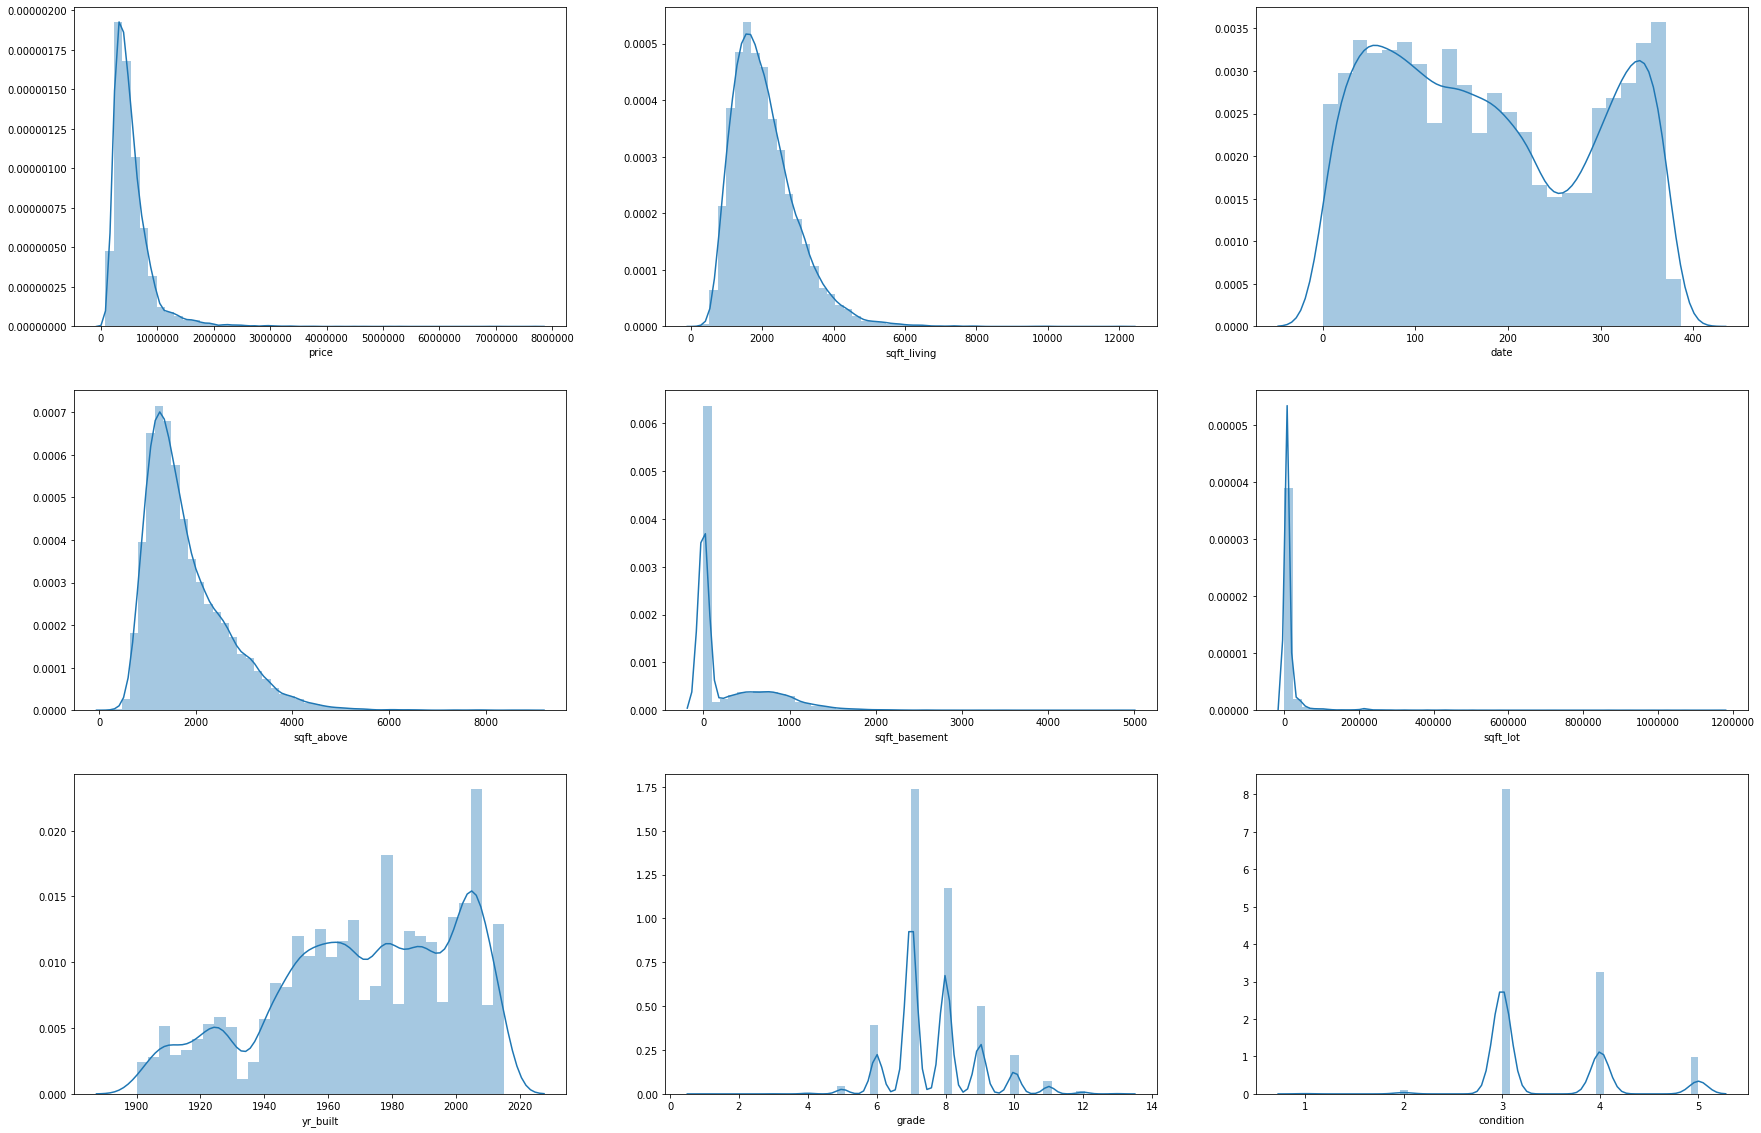

In [16]:
columns_to_plot = ['price', 'sqft_living', 'date',
                   'sqft_above', 'sqft_basement', 'sqft_lot',
                   'yr_built', 'grade', 'condition']

nrow, ncol = 3, 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize = (30, 20))

for i, column in enumerate(columns_to_plot):
    sns.distplot(housing[column], ax=axes[i//nrow, i%ncol])

We can already see some possible problems with this dataset:

The properties have different ranges, from [0-1] range ('waterfront'), to [0-10000] range ('sqft_living'). This might cause problems for some algorithms and make the gradient descent slower. 

Additionally, 'bedrooms' and 'sqft_lot' have a very long-tailed distribution. This might indicate the presence of outliers/errors in the dataset, which might be pesky to deal with later, so we will examine and try to clean up before creating a model. However, determining their possible negative effect will be time consuming and in the real data sets there will always be some outliers like some luxury house prices in this dataset. That's why I am not planning to remove outliers, only errors.

Let's examine the bedrooms first:

In [17]:
counts = housing['bedrooms'].value_counts(ascending=True)
print(counts)

33       1
10       2
9        5
0        8
8        9
7       29
1      153
6      212
5     1292
2     2237
4     5477
3     7865
Name: bedrooms, dtype: int64


As suspected, we have the most data in the 1-6 bedroom range, with several outliers - one of the houses has 33 bedrooms, and some of them have none (!). Let's examine them and see if we can find a pattern

In [18]:
housing.loc[(housing['bedrooms'] == 33)]

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
15870,54,640000.0,0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947


33 bedrooms in 1620sqft seems very suspicious. Lets compare this with similar apartments:

In [19]:
housing.loc[housing['sqft_living'] == 1620].describe()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
count,83.000000,83.000000,83.0,83.000000,83.000000,83.0,83.000000,83.000000,83.0,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,176.506024,443350.578313,0.0,3.469880,1.870482,1620.0,10357.048193,1.530120,0.0,0.216867,3.506024,7.265060,1440.000000,180.000000,1965.409639
std,117.330612,145783.360677,0.0,3.328873,0.511099,0.0,25407.536708,0.631246,0.0,0.827105,0.722014,0.564916,243.570994,243.570994,31.152667
min,3.000000,218000.000000,0.0,2.000000,1.000000,1620.0,997.000000,1.000000,0.0,0.000000,3.000000,6.000000,830.000000,0.000000,1900.000000
25%,75.000000,333975.000000,0.0,3.000000,1.500000,1620.0,3777.500000,1.000000,0.0,0.000000,3.000000,7.000000,1220.000000,0.000000,1947.000000
50%,153.000000,430000.000000,0.0,3.000000,1.750000,1620.0,6000.000000,1.500000,0.0,0.000000,3.000000,7.000000,1620.000000,0.000000,1966.000000
75%,309.500000,525000.000000,0.0,3.000000,2.250000,1620.0,8128.500000,2.000000,0.0,0.000000,4.000000,8.000000,1620.000000,400.000000,1989.000000
max,374.000000,842000.000000,0.0,33.000000,2.750000,1620.0,219542.000000,3.000000,0.0,4.000000,5.000000,9.000000,1620.000000,790.000000,2014.000000


As expected, the actual number of bedrooms in similar apartments is much lower, around 3.5. We can assume for now that this value has been entered incorrectly, and change it to the mean (4), as most of the other fields for this record seem to be in the correct range.

In [20]:
housing.loc[15870, 'bedrooms'] = 4

Now, let's check the apartments with no bedrooms or bathrooms.

In [21]:
rooms_outlier = housing.loc[(housing['bedrooms'] == 0) | (housing['bathrooms'] == 0)]
rooms_outlier.head()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
3119,279,380000.0,0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006
3467,95,288000.0,0,0,1.5,1430,1650,3.0,0,0,3,7,1430,0,1999
1149,291,75000.0,0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966
6994,53,1300000.0,1,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990
19452,147,142000.0,0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963


In [22]:
rooms_outlier.describe()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
count,11.000000,1.100000e+01,11.000000,11.000000,11.000000,11.000000,11.00000,11.000000,11.0,11.000000,11.000000,11.00000,11.000000,11.0,11.000000
mean,193.363636,3.524500e+05,0.090909,0.272727,0.681818,1317.636364,15053.00000,1.636364,0.0,0.181818,2.818182,6.00000,1317.636364,0.0,1971.818182
std,93.969434,3.348026e+05,0.301511,0.467099,1.031327,1263.875569,13745.03052,0.809040,0.0,0.603023,0.873863,3.03315,1263.875569,0.0,29.862412
min,53.000000,7.500000e+04,0.000000,0.000000,0.000000,290.000000,979.00000,1.000000,0.0,0.000000,1.000000,1.00000,290.000000,0.0,1913.000000
25%,142.500000,1.850000e+05,0.000000,0.000000,0.000000,635.000000,4969.00000,1.000000,0.0,0.000000,2.500000,3.50000,635.000000,0.0,1951.500000
50%,153.000000,2.800000e+05,0.000000,0.000000,0.000000,844.000000,7111.00000,1.000000,0.0,0.000000,3.000000,7.00000,844.000000,0.0,1966.000000
75%,285.000000,3.500000e+05,0.000000,0.500000,1.250000,1480.000000,23872.50000,2.000000,0.0,0.000000,3.000000,7.00000,1480.000000,0.0,1999.000000
max,346.000000,1.300000e+06,1.000000,1.000000,2.500000,4810.000000,43377.00000,3.000000,0.0,2.000000,4.000000,12.00000,4810.000000,0.0,2006.000000


We have 11 records, that have either 0 bedrooms, or 0 bathrooms. Once again, we would want clarify whether it is an error or is this one of the use cases for our final model (e.g. predicting prices of garages). For now, we will just get rid of those records.  

In [23]:
housing.drop(rooms_outlier.index, inplace=True)

### Quick price review

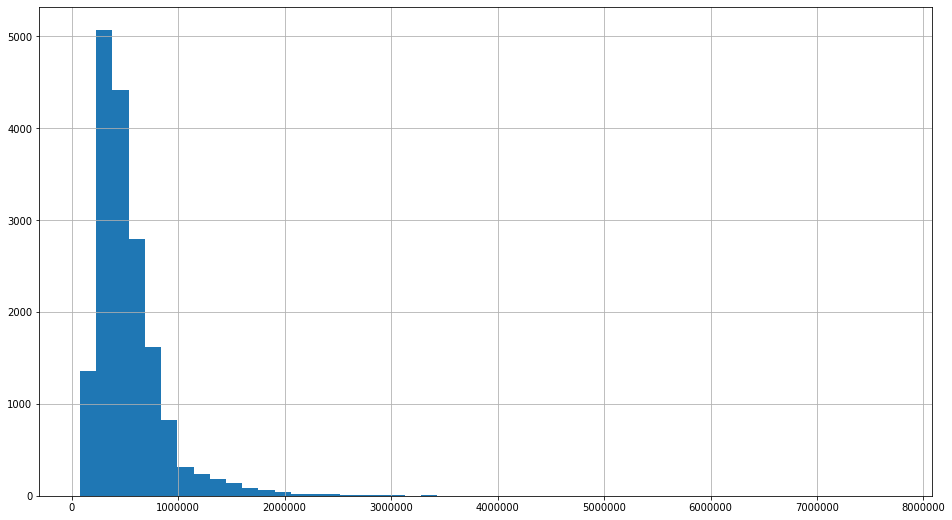

In [24]:
housing['price'].hist(bins=50, figsize=(16, 9))

A very long-tailed distribution, with several outliers. Just like in the real world, there are probably a few mansions that are way outside of the 'ordinary' price range. Just to be sure we dont have errors, lets check a few records from the top:

In [25]:
housing.sort_values(by=['price'], ascending=False).head(10)

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
7252,164,7700000.0,1,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910
3914,40,7060000.0,1,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940
9254,140,6890000.0,1,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001
1315,346,5300000.0,1,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991
1164,171,5110000.0,1,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999
8092,46,4670000.0,1,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983
8638,47,4490000.0,1,4,3.00,6430,27517,2.0,0,0,3,12,6430,0,2001
12370,369,4210000.0,1,5,6.00,7440,21540,2.0,0,0,3,12,5550,1890,2003
7035,60,3800000.0,1,5,5.50,7050,42840,1.0,0,2,4,13,4320,2730,1978
19017,132,3800000.0,1,3,4.25,5510,35000,2.0,0,4,3,13,4910,600,1997


This looks possible, as all of these properties have a very high grade, huge living area and are in decent condition.

# Correlation Matrix

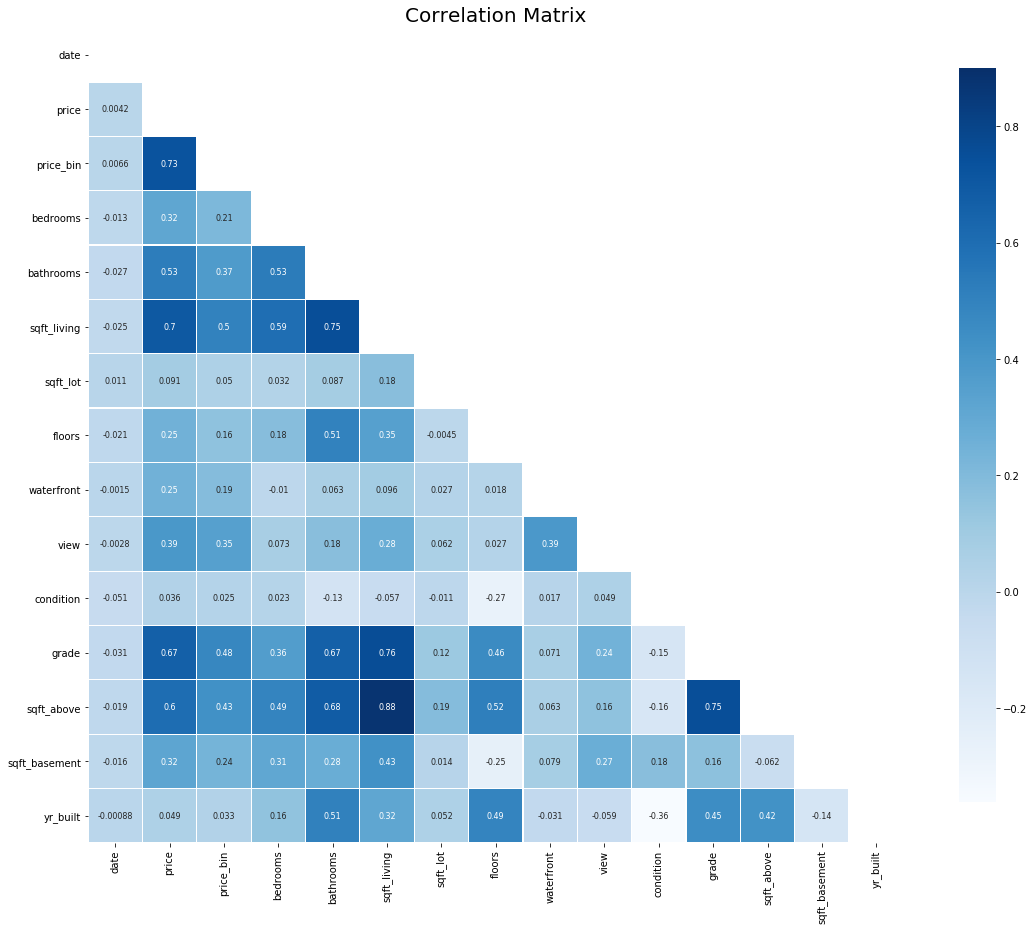

In [26]:
features = ['date', 'price', 'price_bin',
             'bedrooms', 'bathrooms', 'sqft_living',
             'sqft_lot', 'floors', 'waterfront',
            'view', 'condition', 'grade', 
            'sqft_above', 'sqft_basement', 'yr_built']

mask = np.zeros_like(housing[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(20, 15))
plt.title('Correlation Matrix',fontsize=20)

sns.heatmap(housing[features].corr(),linewidths=0.25,vmax=0.9,square=True, cmap='Blues',
            linecolor='w',annot=True,annot_kws={'size':8}, mask=mask, cbar_kws={'shrink': .9});

At this stage, we can start questioning if the 'grade' column is really the slope of the lot. It has a very high correlation with price, and at the same time, there seems to be no flat lots, with the majority of them having 7-8°, which seems suspicious.

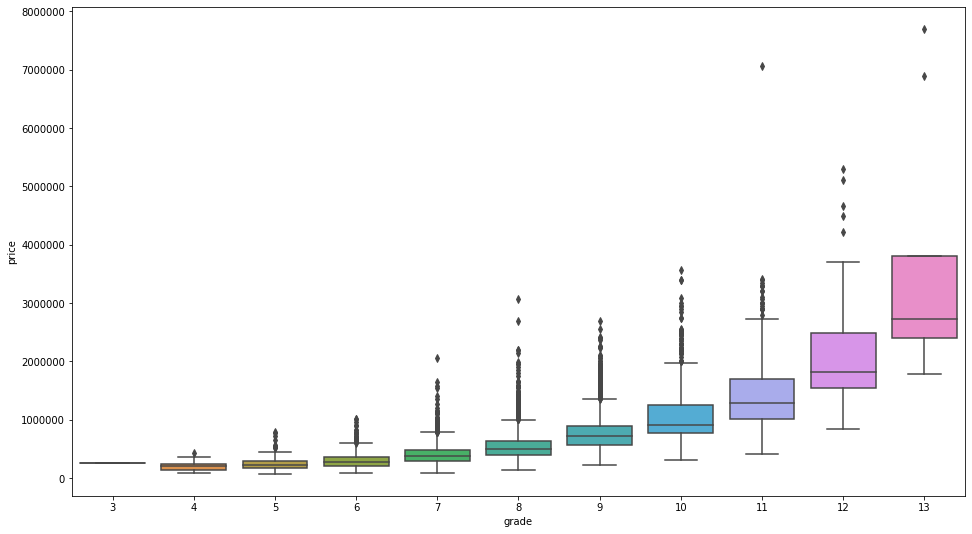

In [27]:
f, axe = plt.subplots(1, 1, figsize=(16,9))
sns.boxplot(x=housing['grade'], y=housing['price'], ax = axe)

Since the data is for King County, WA, this seems to be a better, and more fitting description of grade:
Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc. 

SOURCE: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

This would explain a very high correlation with price much bettar than the lot slope.

## Feature selection

Having too many features in a model is not always a good thing because it might cause overfitting and worse results on the test set. Thus, if a feature does not improve the model be a meaningful margin, not adding it may be a better choice.

Another important thing is correlation. If there is a very high correlation between two features, keeping them both might also lead to overfitting. For instance, if there is overfitting, we may remove sqt_above or sqt_living because they are highly correlated and we can clearly see that sqft_living=sqft_above+sqft_basement. Not all of the features with high correlation are bad though. For example: bathrooms and sqrt_living, which are highly correlated but the relation between them is not the same as the relation between sqt_living and sqt_above.

I will try to select a few features to work with, and we will see if it improves the results of the models.

In [28]:
train_features_all = housing.columns.drop(['price', 'price_bin'])
train_features_selected = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                         'waterfront', 'view', 'grade', 'yr_built']

# Creating simple regression model

In [29]:
X_train = housing[train_features_all]
y_train = housing['price']

In [30]:
#Create df to store results
regression_results = pd.DataFrame(columns=['Name', 'Info', 'RMSE (train)', 'R2 (train)', 'mean_validation', 'std_validation'])

#Calculate metrics we are interested in
def evaluate_regressor(model, X, y, name, info='', scoring='neg_mean_squared_error', cv=5):
    predictions = model.predict(X)
    rmse = np.sqrt(metrics.mean_squared_error(y, predictions))
    r2 = metrics.r2_score(y, predictions)
    
    scores = cross_val_score(model, X, y,
                             scoring=scoring, cv=cv)
    scores = np.sqrt(-scores)
    mean_validation = scores.mean()
    std_validation = scores.std()
    
    print(f'{name} \t RMSE: {rmse:.2f}, R2: {r2:.2f}, mean_val: {mean_validation:.2f}, std_val: {std_validation:.2f}')
    
    nrow = regression_results.shape[0]
    regression_results.loc[nrow] = [name, info, rmse, r2, mean_validation, std_validation]
    

In [31]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
evaluate_regressor(lin_reg, X_train, y_train, name='Linear Regression', info='All features')

Linear Regression 	 RMSE: 212661.85, R2: 0.65, mean_val: 212748.38, std_val: 12715.71


In [32]:
lin_reg_selected = linear_model.LinearRegression()
lin_reg_selected.fit(X_train[train_features_selected], y_train)

evaluate_regressor(lin_reg_selected, X_train[train_features_selected], y_train, name='Linear Regression', info='Selected features')

Linear Regression 	 RMSE: 213464.31, R2: 0.65, mean_val: 213486.79, std_val: 12594.43


In [33]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

evaluate_regressor(tree_reg, X_train, y_train, name='Decision Tree', info='All features')

Decision Tree 	 RMSE: 0.00, R2: 1.00, mean_val: 261101.04, std_val: 8707.68


The decision tree overifts (RMSE 0.00!!!) the training set and gets worse predictions on the validation sets. We could prevent the overfitting by prunning the tree, but at this moment we just want to choose a few models for the next steps.

In [34]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

evaluate_regressor(forest_reg, X_train, y_train, name='Random Forest', info='All features')

Random Forest 	 RMSE: 70663.78, R2: 0.96, mean_val: 187935.11, std_val: 7076.74


In [35]:
forest_reg_selected = RandomForestRegressor(random_state=42)
forest_reg_selected.fit(X_train[train_features_selected], y_train)

evaluate_regressor(forest_reg_selected, X_train[train_features_selected], y_train, name='Random Forest', info='Selected features')

Random Forest 	 RMSE: 76403.35, R2: 0.96, mean_val: 196076.09, std_val: 6335.79


The Random Forest regressor returns the best results on the cross-validation

Let's also try the XGBoost, which is another ensemble model based on decision trees. while in random forests, all of the trees are being built at the same time, each on a random sample of the data, in Gradient Boosting methods (such as XGBoost), the trees are being trained one at a time.

In [36]:
xgb = XGBRegressor(objective ='reg:squarederror')
xgb.fit(X_train, y_train)

evaluate_regressor(xgb, X_train, y_train, name='XGBoost', info='All features')

/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is

XGBoost 	 RMSE: 171932.14, R2: 0.77, mean_val: 187402.35, std_val: 5795.76


In [37]:
xgb_selected = XGBRegressor(objective ='reg:squarederror')
xgb_selected.fit(X_train[train_features_selected], y_train)

evaluate_regressor(xgb_selected, X_train[train_features_selected], y_train, name='XGBoost', info='Selected features')

/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/pablo/Desktop/IT/housing/ml_cpu/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is

XGBoost 	 RMSE: 175640.22, R2: 0.76, mean_val: 189210.18, std_val: 5753.08


In [38]:
regression_results.sort_values(by=['mean_validation'], inplace=True)
regression_results

,Name,Info,RMSE (train),R2 (train),mean_validation,std_validation
5,XGBoost,All features,171932.142589,0.774029,187402.345105,5795.755174
3,Random Forest,All features,70663.777893,0.961829,187935.112887,7076.741995
6,XGBoost,Selected features,175640.222336,0.764177,189210.176979,5753.084622
4,Random Forest,Selected features,76403.348799,0.955377,196076.085846,6335.792643
0,Linear Regression,All features,212661.850472,0.654286,212748.383408,12715.713824
1,Linear Regression,Selected features,213464.308417,0.651672,213486.793291,12594.425697
2,Decision Tree,All features,0.000000,1.000000,261101.035259,8707.684052


It looks like the XGBoost model on all of the features performed the best, with the lowest mean error and standard deviation. It's R^2 score indicates also that it is less prone to overfiting than the Decision Tree and Random Forest classifiers. The random forest overfitted the training set more, but achieved similar results on the validation sets. Those 2 models are the prime candidates for future hyper-parameter tuning.  

## Test performance

Since this will conclude this part of the analysis, as the tuning will be left for future work, we can see how well it performs on the test set. 

In [39]:
X_test = test_set[train_features_all].copy()
y_test_regression = test_set['price']

# Apply the same transformation as for training set
dates_test = pd.to_datetime(X_test['date'])
dates_test -= min(dates_test)
X_test['date'] = dates_test.dt.days

In [40]:
test_predictions = xgb.predict(X_test)
test_errors = abs(y_test_regression - test_predictions)
print(f'Performance on test data -  Average error: {test_errors.mean():.2f}$, Standard Deviation: {test_errors.std():.2f}$, Max error: {test_errors.max():.2f}$')

Performance on test data -  Average error: 130282.88$, Standard Deviation: 164860.53$, Max error: 3340399.50$


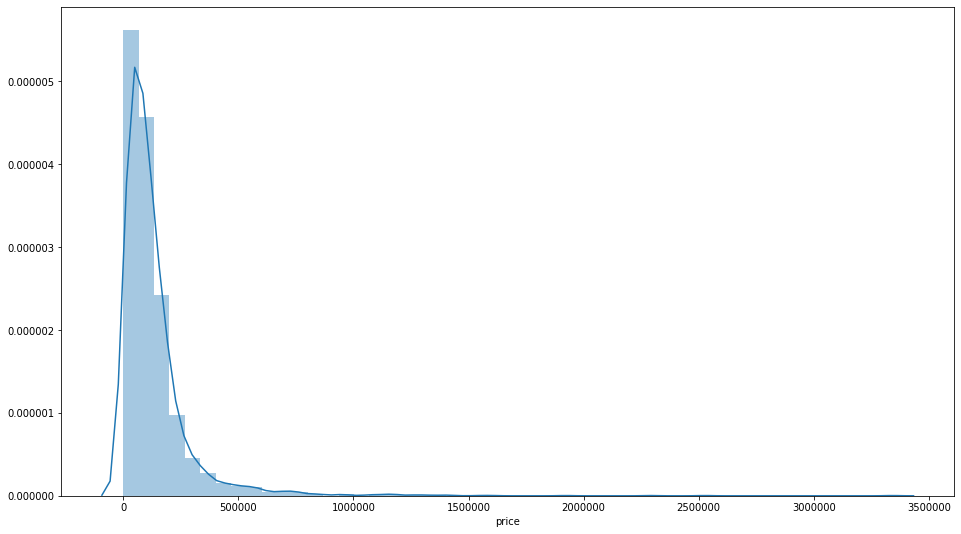

In [41]:
sns.distplot(test_errors)

The test performance does not look good, the model is off by over a  100 thousand dollars on average, with maximum error at 3.4 milion dollars! That's not a satisfactory result.

I will talk about the suspected root cause right after testing a few classifiers

# Creating Classifier

In [42]:
X_train = housing[train_features_all]
y_train_classification = housing['price_bin']

In [64]:
classification_results = pd.DataFrame(columns=['Name', 'Info', 'Accuracy (train)', 'F1(train)', 'mean_validation', 'std_validation'])

def evaluate_classifier(model, X, y, name, info='', cv=5):
    predictions = model.predict(X)
    f1 = metrics.f1_score(y, predictions)
    accuracy = metrics.accuracy_score(y, predictions)
    
    scores = cross_val_score(model, X, y, cv=cv)
    mean_validation = scores.mean()
    std_validation = scores.std()
    
    print(f'{name} \t F1: {f1:.2f}, Accuracy: {accuracy:.2f}, mean_val: {mean_validation:.2f}, std_val: {std_validation:.2f}')
    
    nrow = classification_results.shape[0]
    classification_results.loc[nrow] = [name, info, f1, accuracy, mean_validation, std_validation]

In [65]:
sgd_clf = linear_model.SGDClassifier()
sgd_clf.fit(X_train, y_train_classification)

evaluate_classifier(sgd_clf, X_train, y_train_classification, 'SGD', 'All features')

SGD 	 F1: 0.51, Accuracy: 0.92, mean_val: 0.89, std_val: 0.08


In [66]:
sgd_clf_selected = linear_model.SGDClassifier()
sgd_clf_selected.fit(X_train[train_features_selected], y_train_classification)

evaluate_classifier(sgd_clf_selected, X_train[train_features_selected], y_train_classification, 'SGD', 'Selected features')

SGD 	 F1: 0.08, Accuracy: 0.94, mean_val: 0.94, std_val: 0.02


In [67]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train_classification)

evaluate_classifier(forest_clf, X_train, y_train_classification, 'Random Forest', 'All features')

SGD 	 F1: 1.00, Accuracy: 1.00, mean_val: 0.96, std_val: 0.00


In [68]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train_classification)

evaluate_classifier(xgb_clf, X_train, y_train_classification, 'XGBOOST', 'All features')

XGBOOST 	 F1: 0.71, Accuracy: 0.97, mean_val: 0.96, std_val: 0.00


In [70]:
xgb_clf_selected = XGBClassifier()
xgb_clf_selected.fit(X_train[train_features_selected], y_train_classification)

evaluate_classifier(xgb_clf_selected, X_train[train_features_selected], y_train_classification, 'XGBOOST', 'Selected features')

XGBOOST 	 F1: 0.70, Accuracy: 0.96, mean_val: 0.96, std_val: 0.00


In [73]:
classification_results.sort_values(by=['mean_validation'], ascending=False, inplace=True)
classification_results

,Name,Info,Accuracy (train),F1(train),mean_validation,std_validation
3,XGBOOST,All features,0.714709,0.966549,0.961919,0.002186
2,SGD,All features,1.000000,1.000000,0.961572,0.002340
4,XGBOOST,Selected features,0.695050,0.964350,0.960993,0.002466
1,SGD,All features,0.080537,0.936570,0.935816,0.020382
0,SGD,All features,0.513197,0.915678,0.888827,0.077242


Once again, the XGBoost turned out to be the best model, and the feature selection did not bring any improvement.

In [81]:
predictions = xgb_clf.predict(X_test[train_features_all])
y_test_classification = test_set['price_bin']
test_accuracy = 1 - sum(predictions!=y_test_classification)/len(predictions)
print(f'Accuracy on test set: {test_accuracy:.2f}')

Accuracy on test set: 0.95


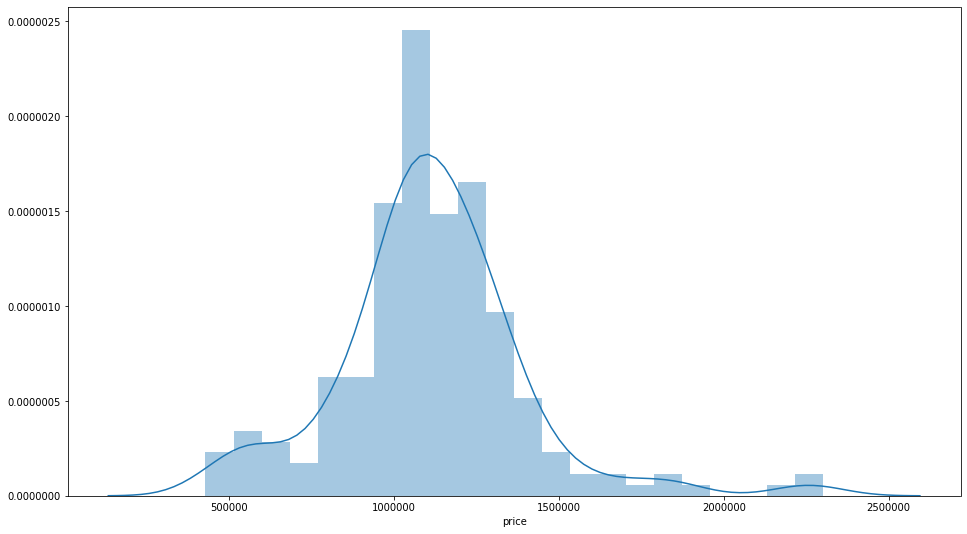

In [82]:
sns.distplot(test_set['price'][predictions!=y_test_classification])

While we expected some errors around the threshold, the errors further from the 1,000,000 seem very suspicious...

Until we think about what features we have at our disposal. There is a key element missing - the localization of the house. Identical house inside the city center is worth several times more than house in the suburbs.

We can confirm this suspicion by plotting the house prices on a map:

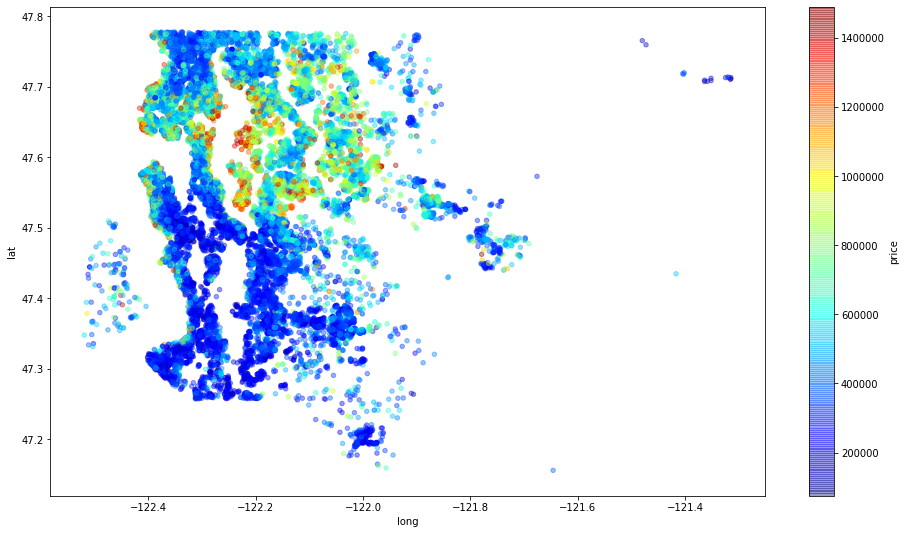

In [83]:
#analyze houses up to threshold for better visuals
threshold = 1500000
cheaper_houses = full_data[full_data['price'] < threshold]

cheaper_houses.plot(kind='scatter', x="long", y="lat", alpha=0.4,
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

We can clearly see that the price of a house is strongly correlated with its location. It would not make much more sense to pursue higher accuracy, without including the location of the house in the analysis. 

# Conclusions & future work

As a result two models have been created - one for continous price predictions, the second one for predicting whether the house is worth more than 1 milion dollars. 

The models perfrom their respective tasks with acceptable accuracy: 

In order to improve the predictions, I would try the following things:
1. Include house location into its features - this should provide us with the *biggest improvement*.
  1. As seen on the map above, the most expensive houses could be found in places closer to the city center. 
  2. Without including this data, it might be 'impossible' to obtain better predictions. This is motivated by the fact, that even humans would not be able to accurately judge the price of a house without knowing its location.
  3. Exploring how to include the location in the model is a topic for entire discussion. We could first try with simple coordinates ('lat', 'long' in the dataset), but this information alone does not give us a full picture. The next thing to try might be calculating distance from the 'city center', or manually picked point with most expensive prices of m^2. Another approach could rely on one-hot encoded zip-codes or the names of the neighbourhoods.
  
2. Test how feature scaling affects the predictions. While some models should not be impacted by this (e.g. decision trees/random forests), we have multiple features with widely different scales and very heavy-tailed distributions. Additionally, after deciding what type of data transformations are to be used, a pipeline (e.g. using [sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) that would take input data and transform it into the data that is being fed into the model. This would ensure much easier reproducibility 

3. Hyperparameter tuning. So far, the models were used as-is, without going into too much details. I'd start with the most promissing model and spend some time testing if I can find better combinations of hyperparameters (e.g. depth, number of estimators for random forests). GridSearchCV and RandomizedSearchCV could provide first steps in this direction.

4. Try a simple neural network and compare its results with previous models. This of course, would further decrease the explainability of the model (even compared to the Random Forests), but could provide us with the better results. Depending on the bussiness requirements, we might care about this enough to not use any type of deep learning and default to easily explainable models (such as decision trees). This would be the case if there are regulations imposed and we have to explain how we arrived at our prices. 

5. Get more data - pretty self explainatory, harder to achieve. More data can increase the accuracy of the models, but the cost of buying/scraping more data might outweight any possible improvements. 

Most of the steps would be done on the training/validation data, with test data used just at the last stage to check how well the trained models can generalize on data that was previously unseen. 

One more thing, that is not strictly related to the model training would be cleanup - it would be easier to maintain and share with other team memberes if the functions were moved to seperate .py files and imported into the notebook. 

After obtaining a finished model, we have several ways of deploying it. Several factors would impact the final decision at this stage, such as:
1. Is the model going to be used internally, or should be available for the final customer? 
2. How many requests are we expecting? 
3. Do we need to serve the predictions in real time? 
4. Are we planning on-prem deployment or cloud?

After deployment, the next part would be model maintanence, where we should estabilish a way of monitoring the model and creating a pipeline to re-learn it every few weeks/months with new data (as the house prices for sure wont stay exactly the same!).

